<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Zahra Maleki'
std_id = '400110009'

In [2]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt
import torch.nn.functional as F
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from tqdm import tqdm

In [28]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [29]:
# TODO: Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
    # ,transforms.Normalize((0.5,), (0.5,))  # Normalize the images with mean and std of 0.5
])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [30]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=100, shuffle=True)


print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [31]:
def plot_class_distribution(dataloader):
    # TODO: Initialize a dictionary to count occurrences of each class
    class_counts = {i: 0 for i in range(10)}
    # TODO: Iterate through the DataLoader to count the labels
    for _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1

    # TODO: Plot the histogram
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts, tick_label=[str(i) for i in classes])
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Class Distribution in Dataset')
    plt.show()

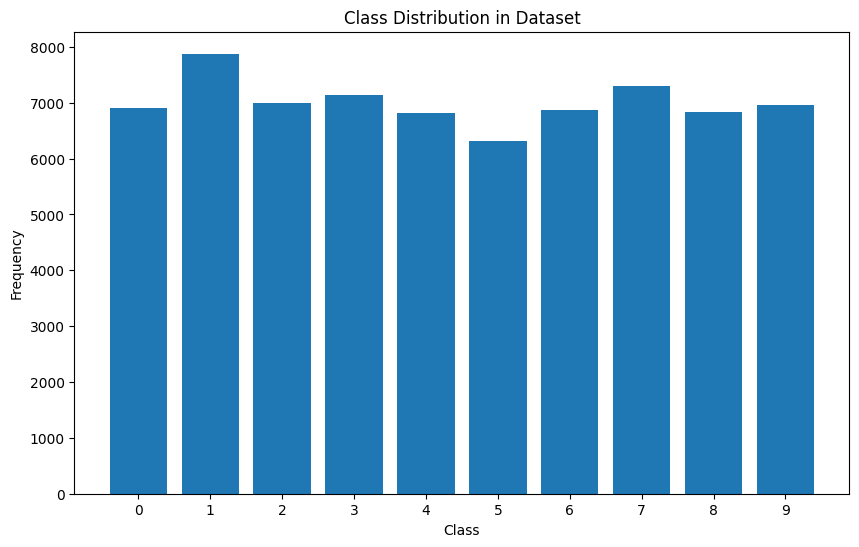

In [7]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [32]:
def plot_class_averages(dataloader):
    # TODO: Iterate over the DataLoader to accumulate sums and counts
    class_sums = {i: torch.zeros((28, 28)) for i in range(10)}
    class_counts = {i: 0 for i in range(10)}

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            label = label.item()
            class_sums[label] += img.squeeze()
            class_counts[label] += 1

    # TODO: Calculate the average images for each class
    class_averages = {i: class_sums[i] / class_counts[i] for i in range(10)}


    # TODO: Plot the averages
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(class_averages[i].numpy(), cmap='gray')
        plt.title(f'Class {i}')
        plt.axis('off')

    plt.suptitle('Average Images for Each Class')
    plt.show()

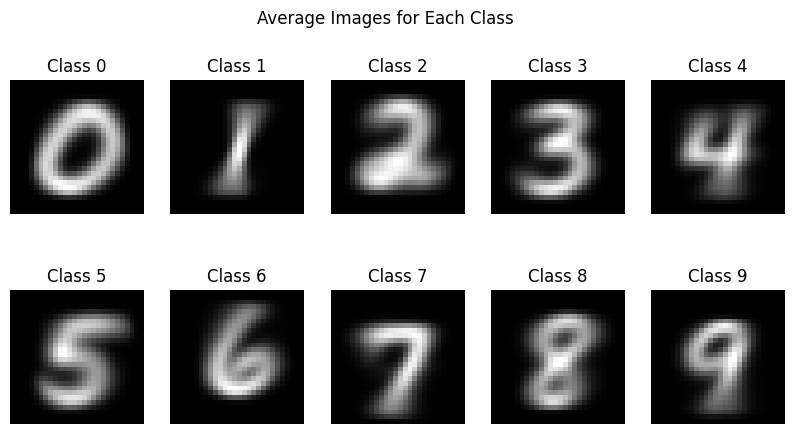

In [33]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [34]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200):
        # TODO
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(

            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        # self.fc1 = nn.Linear(input_dim, hidden_dim)
        # self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        # self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        self.decoder = nn.Sequential(

            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
        # Decoder layers
        # self.fc3 = nn.Linear(latent_dim, hidden_dim)
        # self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        # TODO
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
        # h1 = F.relu(self.fc1(x))
        # mean = self.fc_mean(h1)
        # log_var = self.fc_var(h1)
        # return mean, log_var

    def reparameterization(self, mean, var):
        # TODO
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z
        # std = torch.exp(0.5 * log_var)
        # eps = torch.randn_like(std)
        # z = mean + eps * std
        # return z

    def decode(self, z):
        # TODO
        return self.decoder(z)
        # h3 = F.relu(self.fc3(z))
        # reconstruction = torch.sigmoid(self.fc4(h3))
        # return reconstruction

    def forward(self, x):
        # TODO
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mean, log_var

In [104]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [ ]:
def loss_function(x, x_hat, mean, log_var, recon_weight=1.0, kl_weight=1.0):
    # TODO

    reconstruction_loss = F.binary_cross_entropy(x_hat, x, reduction='sum') 

    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    total_loss = reconstruction_loss + kl_divergence

    return total_loss, reconstruction_loss, kl_divergence

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [105]:
def plot_losses(losses):
    # TODO
    plt.plot(losses,label='Training Loss')
    # plt.ylim(130,180)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()


def train(model, optimizer, n_epochs=60, losses=losses):
    # TODO

    model.train()

    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch in tqdm(merged_loader):

            images, _ = batch
            # images = images.view(images.size(0), -1).to(device)

            batch_size = 100 

            images = images.view(batch_size,-1).to(device)

            optimizer.zero_grad()

            # images = (images + 1) / 2

            reconstruction, mean, log_var = model(images)

            loss, recon_loss, kl_loss = loss_function(images, reconstruction, mean, log_var)


            epoch_loss += loss.item()

            # optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_loss = epoch_loss / len(merged_loader.dataset)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{n_epochs}], Total Loss: {avg_loss:.4f}")


    plot_losses(losses)
    return losses

100%|██████████| 700/700 [00:08<00:00, 82.36it/s] 


Epoch [1/60], Total Loss: 175.8777


100%|██████████| 700/700 [00:08<00:00, 87.37it/s]


Epoch [2/60], Total Loss: 156.1608


100%|██████████| 700/700 [00:08<00:00, 82.45it/s]


Epoch [3/60], Total Loss: 150.4277


100%|██████████| 700/700 [00:23<00:00, 29.84it/s]


Epoch [4/60], Total Loss: 147.2546


100%|██████████| 700/700 [00:14<00:00, 49.05it/s]


Epoch [5/60], Total Loss: 145.0976


100%|██████████| 700/700 [00:24<00:00, 28.45it/s] 


Epoch [6/60], Total Loss: 143.6789


100%|██████████| 700/700 [00:18<00:00, 38.15it/s] 


Epoch [7/60], Total Loss: 142.6238


100%|██████████| 700/700 [00:16<00:00, 41.50it/s]


Epoch [8/60], Total Loss: 141.6831


100%|██████████| 700/700 [00:08<00:00, 82.76it/s]


Epoch [9/60], Total Loss: 140.9729


100%|██████████| 700/700 [00:07<00:00, 89.25it/s] 


Epoch [10/60], Total Loss: 140.2374


100%|██████████| 700/700 [00:29<00:00, 24.05it/s] 


Epoch [11/60], Total Loss: 139.8548


100%|██████████| 700/700 [00:18<00:00, 37.39it/s] 


Epoch [12/60], Total Loss: 139.1204


100%|██████████| 700/700 [00:28<00:00, 24.40it/s]


Epoch [13/60], Total Loss: 138.6441


100%|██████████| 700/700 [00:47<00:00, 14.76it/s]


Epoch [14/60], Total Loss: 138.2708


100%|██████████| 700/700 [00:46<00:00, 15.03it/s]


Epoch [15/60], Total Loss: 137.8026


100%|██████████| 700/700 [00:38<00:00, 18.36it/s]


Epoch [16/60], Total Loss: 137.4676


100%|██████████| 700/700 [00:36<00:00, 19.03it/s]


Epoch [17/60], Total Loss: 137.0640


100%|██████████| 700/700 [00:35<00:00, 19.61it/s]


Epoch [18/60], Total Loss: 136.7690


100%|██████████| 700/700 [00:39<00:00, 17.89it/s]


Epoch [19/60], Total Loss: 136.4182


100%|██████████| 700/700 [00:37<00:00, 18.66it/s]


Epoch [20/60], Total Loss: 136.1003


100%|██████████| 700/700 [00:11<00:00, 63.05it/s] 


Epoch [21/60], Total Loss: 135.9110


100%|██████████| 700/700 [00:06<00:00, 103.72it/s]


Epoch [22/60], Total Loss: 135.6849


100%|██████████| 700/700 [00:04<00:00, 148.95it/s]


Epoch [23/60], Total Loss: 135.6700


100%|██████████| 700/700 [00:04<00:00, 159.25it/s]


Epoch [24/60], Total Loss: 135.1787


100%|██████████| 700/700 [00:04<00:00, 159.62it/s]


Epoch [25/60], Total Loss: 135.0080


100%|██████████| 700/700 [00:04<00:00, 158.69it/s]


Epoch [26/60], Total Loss: 134.9407


100%|██████████| 700/700 [00:04<00:00, 160.62it/s]


Epoch [27/60], Total Loss: 134.6485


100%|██████████| 700/700 [00:04<00:00, 159.88it/s]


Epoch [28/60], Total Loss: 134.4222


100%|██████████| 700/700 [00:04<00:00, 154.98it/s]


Epoch [29/60], Total Loss: 134.5012


100%|██████████| 700/700 [00:03<00:00, 177.79it/s]


Epoch [30/60], Total Loss: 134.1368


100%|██████████| 700/700 [00:03<00:00, 177.32it/s]


Epoch [31/60], Total Loss: 134.0680


100%|██████████| 700/700 [00:03<00:00, 178.97it/s]


Epoch [32/60], Total Loss: 133.8326


100%|██████████| 700/700 [00:03<00:00, 178.27it/s]


Epoch [33/60], Total Loss: 133.7485


100%|██████████| 700/700 [00:03<00:00, 176.37it/s]


Epoch [34/60], Total Loss: 133.6643


100%|██████████| 700/700 [00:04<00:00, 156.95it/s]


Epoch [35/60], Total Loss: 133.4803


100%|██████████| 700/700 [00:05<00:00, 137.64it/s]


Epoch [36/60], Total Loss: 133.2770


100%|██████████| 700/700 [00:17<00:00, 39.34it/s]


Epoch [37/60], Total Loss: 133.1887


100%|██████████| 700/700 [00:17<00:00, 40.59it/s]


Epoch [38/60], Total Loss: 133.1732


100%|██████████| 700/700 [00:17<00:00, 40.54it/s]


Epoch [39/60], Total Loss: 132.9295


100%|██████████| 700/700 [00:17<00:00, 39.12it/s]


Epoch [40/60], Total Loss: 132.8902


100%|██████████| 700/700 [00:18<00:00, 38.22it/s]


Epoch [41/60], Total Loss: 132.7815


100%|██████████| 700/700 [00:17<00:00, 39.97it/s]


Epoch [42/60], Total Loss: 132.5987


100%|██████████| 700/700 [00:17<00:00, 40.55it/s]


Epoch [43/60], Total Loss: 132.6582


100%|██████████| 700/700 [00:16<00:00, 41.42it/s]


Epoch [44/60], Total Loss: 132.4480


100%|██████████| 700/700 [00:16<00:00, 41.27it/s]


Epoch [45/60], Total Loss: 132.4974


100%|██████████| 700/700 [00:17<00:00, 41.08it/s]


Epoch [46/60], Total Loss: 132.2624


100%|██████████| 700/700 [00:08<00:00, 86.94it/s] 


Epoch [47/60], Total Loss: 132.2204


100%|██████████| 700/700 [00:05<00:00, 136.81it/s]


Epoch [48/60], Total Loss: 132.1158


100%|██████████| 700/700 [00:04<00:00, 145.44it/s]


Epoch [49/60], Total Loss: 132.1207


100%|██████████| 700/700 [00:04<00:00, 148.38it/s]


Epoch [50/60], Total Loss: 131.9193


100%|██████████| 700/700 [00:04<00:00, 150.73it/s]


Epoch [51/60], Total Loss: 131.8464


100%|██████████| 700/700 [00:04<00:00, 148.07it/s]


Epoch [52/60], Total Loss: 131.7736


100%|██████████| 700/700 [00:04<00:00, 150.31it/s]


Epoch [53/60], Total Loss: 131.7087


100%|██████████| 700/700 [00:04<00:00, 169.24it/s]


Epoch [54/60], Total Loss: 131.7146


100%|██████████| 700/700 [00:04<00:00, 168.70it/s]


Epoch [55/60], Total Loss: 131.3934


100%|██████████| 700/700 [00:04<00:00, 166.82it/s]


Epoch [56/60], Total Loss: 131.5705


100%|██████████| 700/700 [00:04<00:00, 166.97it/s]


Epoch [57/60], Total Loss: 131.4801


100%|██████████| 700/700 [00:04<00:00, 169.67it/s]


Epoch [58/60], Total Loss: 131.5377


100%|██████████| 700/700 [00:04<00:00, 165.06it/s]


Epoch [59/60], Total Loss: 131.2609


100%|██████████| 700/700 [00:04<00:00, 168.71it/s]


Epoch [60/60], Total Loss: 131.2476


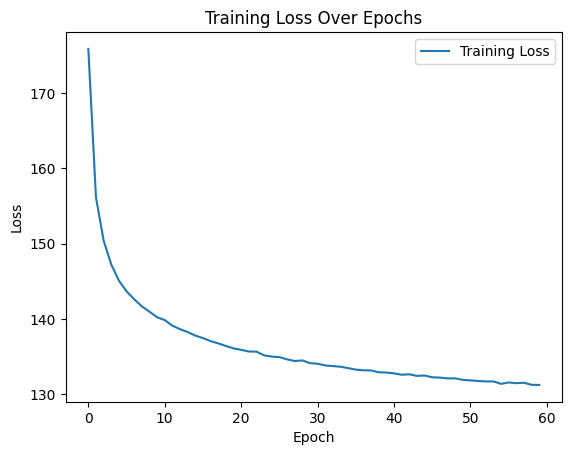

In [106]:
losses += train(model, optimizer)

In [107]:
torch.save(model.state_dict(), 'vae_model.pth')
print(f"Model saved")

Model saved


In [81]:
model = VAE().to(device)
model.load_state_dict(torch.load('vae_model.pth'))
print("Model loaded successfully")

Model loaded successfully


# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [86]:
from sklearn.manifold import TSNE
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    vae.eval()
    z_values, labels = [], []

    with torch.no_grad():
        for i, (data, label) in enumerate(dataloader):
            if i >= batch_count:
                break
            data = data.view(data.size(0), -1)
            mean, _ = vae.encode(data.to(device))
            z_values.append(mean.cpu().numpy())
            labels.append(label.cpu().numpy())

    z_values = np.concatenate(z_values)
    labels = np.concatenate(labels)

    # z_values = (z_values - np.mean(z_values, axis=0)) / np.std(z_values, axis=0)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_values[:, 0], z_values[:, 1], c=labels, cmap='tab10', s=40)
    plt.colorbar(scatter, label='Digit Label')
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    # plt.ylim(-2,1.5)
    # plt.xlim(-2,3)
    plt.show()

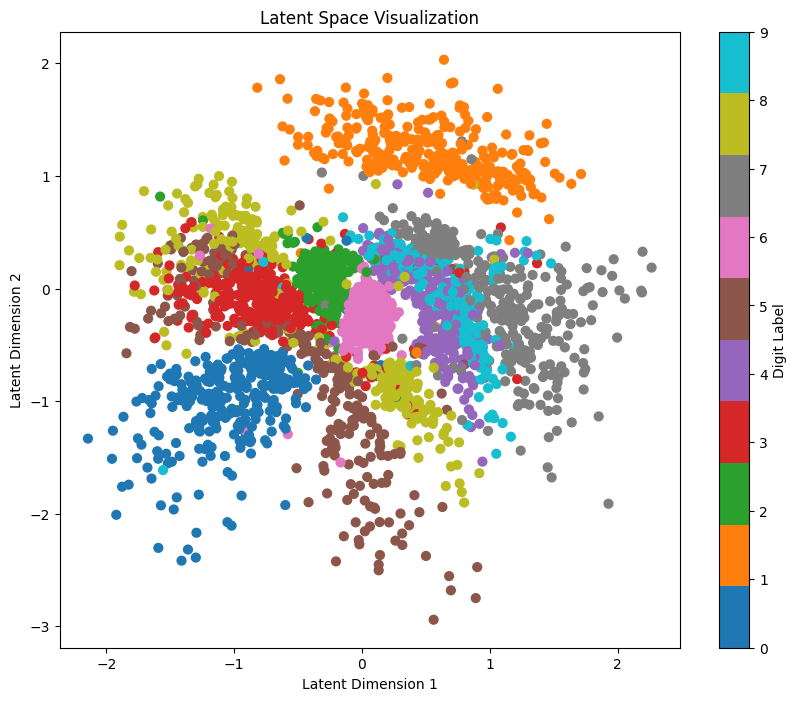

In [87]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [88]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    vae.eval()
    z_values, labels = [], []

    with torch.no_grad():
        for i, (data, label) in enumerate(dataloader):
            if i >= batch_count:
                break
            # Invert the images
            data = 1 - data
            data = data.view(data.size(0), -1)
            mean, _ = vae.encode(data.to(device))
            z_values.append(mean.cpu().numpy())
            labels.append(label.cpu().numpy())

    z_values = np.concatenate(z_values)
    labels = np.concatenate(labels)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_values[:, 0], z_values[:, 1], c=labels, cmap='tab10', s=40)
    plt.colorbar(scatter, label='Digit Label')
    plt.title(title)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

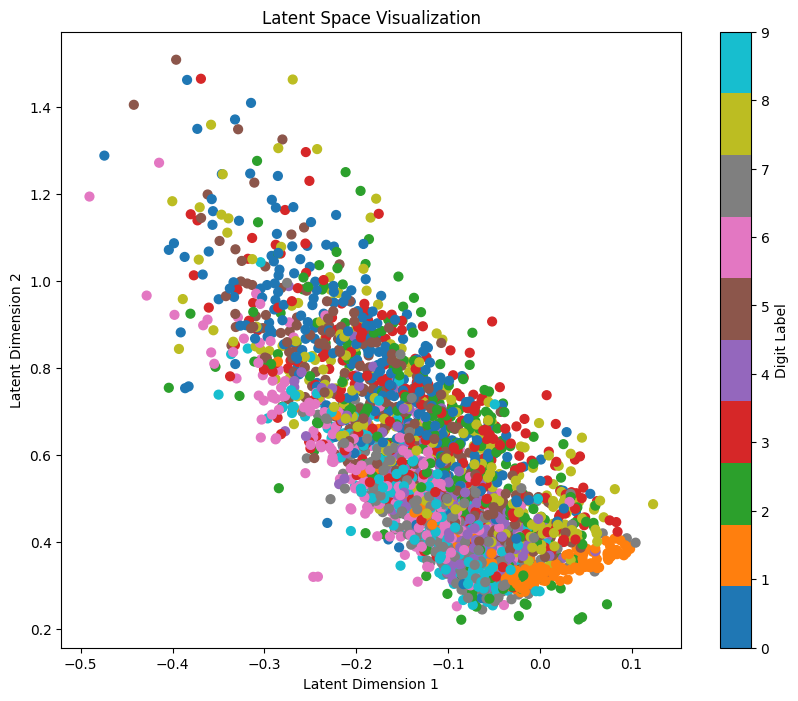

In [89]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

### 1. **Difference in Latent Dimensions and Detecting Out-of-Distribution (OOD) Samples**
   - **Original vs. Inverted Distribution**: The first plot (presumably the original data distribution) shows a relatively well-separated structure in the latent space, with clusters corresponding to different digits. This organization indicates that the VAE has learned to represent each digit distinctly, based on the original MNIST distribution.
   - **Inverted Data Distribution**: The second plot (presumably with inverted images) shows a more elongated, mixed latent representation. Since the inverted images deviate from the distribution the VAE was trained on, the model struggles to organize these data points similarly. This “compression” or scattering is a signature of data that doesn’t follow the training distribution.
   - **Anomaly Detection**: The difference between the latent spaces can be used to detect anomalies. When a new data sample falls significantly outside the typical latent cluster, it may indicate an anomaly or an OOD sample. For example, calculating the Mahalanobis distance or a similar metric from the cluster centroids in the original latent space could help in identifying samples that deviate substantially.

### 2. **Using Autoencoders for Anomaly Detection**
   - **Latent Space Observation**: In an autoencoder, the encoder-decoder pipeline is trained to minimize reconstruction error directly. If we were to use an autoencoder instead of a VAE, we might not get as structured a latent space as seen in the VAE. Instead, the autoencoder would focus on learning a compressed representation sufficient to reconstruct the original input.
   - **Reconstruction Error as an Anomaly Measure**: Autoencoders typically detect anomalies by their inability to reconstruct data that deviates from the training distribution. An inverted image might yield a significantly higher reconstruction error since the autoencoder is optimized to reconstruct the original distribution. This error could then be used to flag OOD samples without directly inspecting the latent space.
   - **Expected Outcome**: With the autoencoder, inverted images would likely result in blurred or distorted reconstructions due to their deviation from the original training data, leading to higher reconstruction errors. This can serve as an alternative signal for identifying anomalous samples.

The VAE allows for OOD detection through deviations in the latent space structure, while an autoencoder focuses on identifying OOD samples by increased reconstruction errors. Both methods are effective, but they leverage different aspects of the model architecture.

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

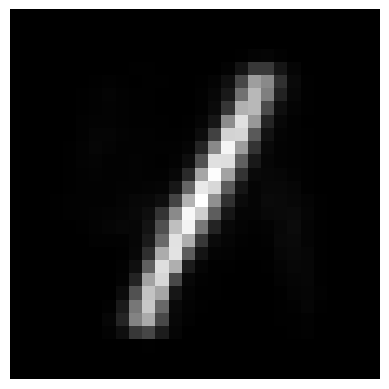

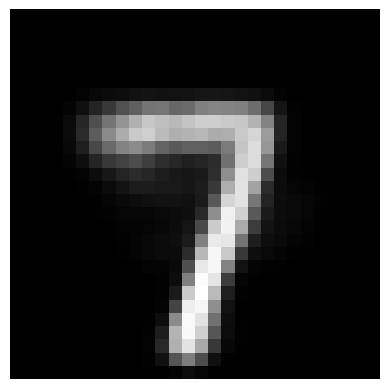

(None, None)

In [90]:
def generate_digit(mean, var):
    # TODO: Return the generated image

    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)


    digit = x_decoded.detach().cpu().reshape(28, 28)
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [91]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid
    # TODO: Generate images for the grid
    # TODO: Display the results

    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

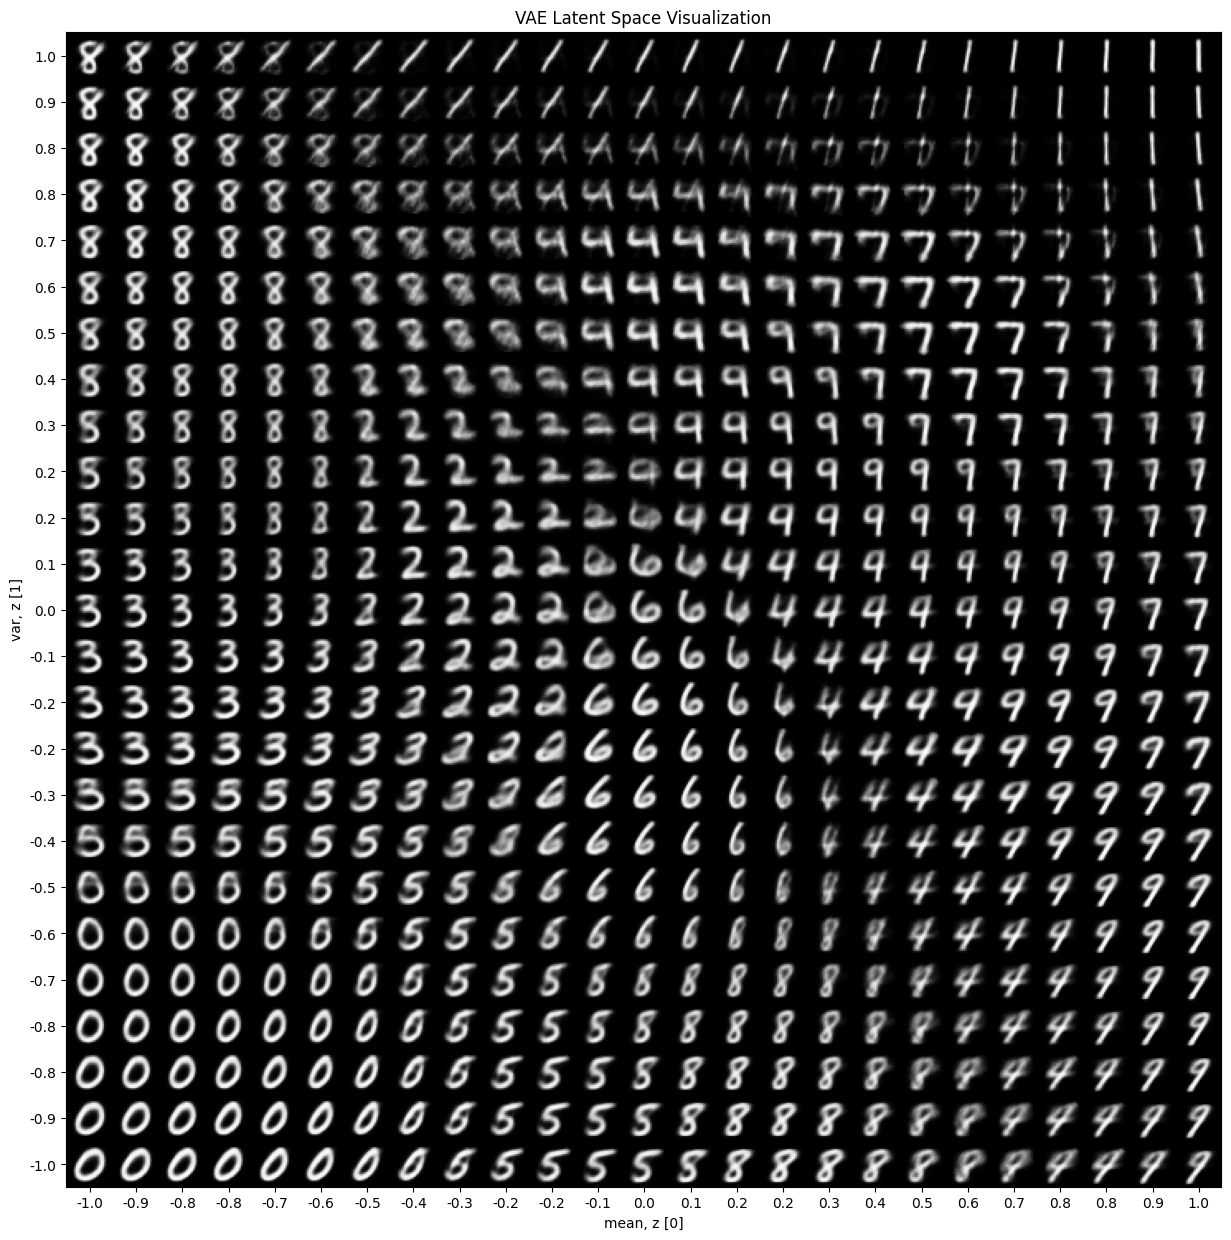

In [92]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*

When you sample from regions outside the dense latent space of a variational autoencoder (VAE), you may get unrealistic or distorted outputs. This happens because VAEs use a regularization term (Kullback-Leibler divergence) that constrains the latent space to follow a Gaussian distribution, allowing the decoder to generate meaningful outputs only from this compact region.

In contrast, a simple autoencoder lacks this regularization. It learns to map inputs to latent variables without imposing a specific structure, so the latent space is less organized. As a result, sampling randomly from a simple autoencoder's latent space often produces outputs that don't resemble the training data, as there’s no guarantee that nearby points in the latent space represent similar inputs.